# Cold War Data Collection

In [1]:
import numpy as np
import scipy.stats

import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
COW = "/Users/dmasad/Data/COW/"

# Getting data

The original model takes the 36 most powerful countries in 1948 (as ranked by the Correlates of War dataset), and computes their position based on their similarity to the US and USSR. Here, I attempt to generate the same data using the most recent COW data.

In [3]:
start_year = 1948
#N = 36
N = 100

## NMC Data

In [4]:
nmc = pd.read_csv(COW + "NMC_v4_0.csv")
nmc = nmc[nmc.year==start_year].copy()
nmc.sort("cinc", ascending=False, inplace=True)
cinc = nmc.head(N)

In [5]:
system_members = pd.read_csv(COW + "SystemMembership2011/states2011.csv")
system_members = system_members.drop_duplicates("ccode")

In [6]:
cinc = cinc.merge(system_members[["ccode", "statenme"]], how='left', on="ccode")

In [7]:
cinc.sort("cinc", ascending=False)

,stateabb,ccode,year,irst,milex,milper,pec,tpop,upop,cinc,version,statenme
0,USA,2,1948,80413,10960998,1446,1396394,147208,42019,0.294660,4,United States of America
1,RUS,365,1948,18639,13157894,2900,232947,178000,30636,0.164000,4,Russia
2,CHN,710,1948,76,214176,3690,13078,562755,33699,0.115055,4,China
3,UKG,200,1948,15116,3438984,847,233072,50026,18852,0.075426,4,United Kingdom
4,IND,750,1948,1277,275196,321,34071,349430,20631,0.052450,4,India
5,FRN,220,1948,7236,910344,577,80735,41044,6740,0.032589,4,France
6,POL,290,1948,1955,4220484,204,41444,23980,3055,0.029854,4,Poland
7,ITA,325,1948,2125,446073,310,15555,46381,9130,0.019262,4,Italy
8,SPN,230,1948,624,235294,464,14988,27437,6388,0.014860,4,Spain
9,CZE,315,1948,2621,537758,250,31659,12339,1684,0.012601,4,Czechoslovakia


## Alliance network

In [8]:
alliance_dyads = pd.read_csv(COW + "Alliances/alliance_v4.1_by_dyad_yearly.csv")
alliance_dyads = alliance_dyads[alliance_dyads.year==start_year]
alliance_dyads["Alliance"] = 0
alliance_dyads.loc[(alliance_dyads.entente==1),"Alliance"] = 1
alliance_dyads.loc[(alliance_dyads.nonaggression==1),"Alliance"] = 2
alliance_dyads.loc[(alliance_dyads.neutrality==1),"Alliance"] = 3
alliance_dyads.loc[(alliance_dyads.defense==1),"Alliance"] = 4

In [9]:
ccode_to_name = {}
for key, val in alliance_dyads.groupby(["ccode1", "state_name1"]):
    ccode, name = key
    ccode_to_name[ccode] = name
for key, val in alliance_dyads.groupby(["ccode2", "state_name2"]):
    ccode, name = key
    ccode_to_name[ccode] = name

In [10]:
G = nx.Graph()
for i, row in alliance_dyads.iterrows():
    G.add_edge(row.state_name1, row.state_name2, weight=row.Alliance)

(-0.25, 8.25)

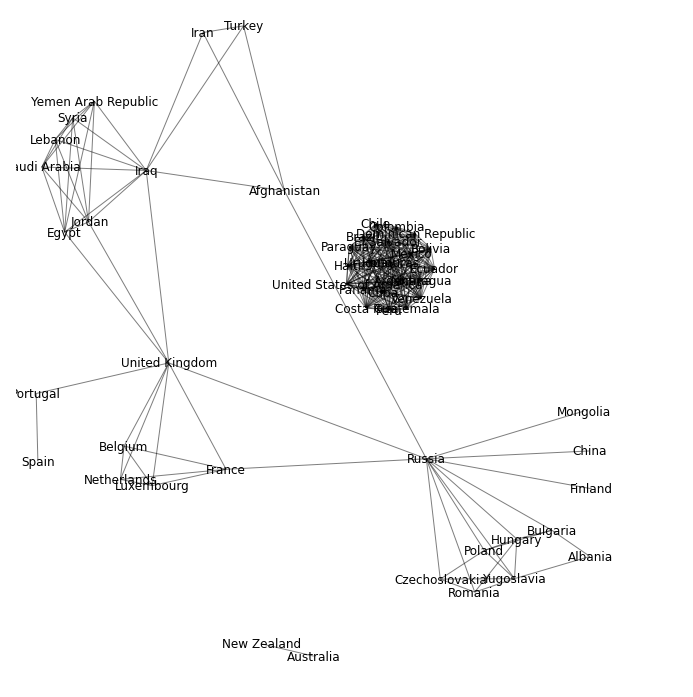

In [11]:
pos = nx.spring_layout(G, k=0.15, scale=8)

fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off')

#nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.5)
nx.draw_networkx_labels(G, pos=pos)

ax.set_xlim(-0.25, 8.25)
ax.set_ylim(-0.25, 8.25)

**Compute similarity using Kendall's Tau**

In [12]:
names = {node: i for i, node in enumerate(G.nodes())}
mat = nx.to_numpy_matrix(G)

def get_tau(state_1, state_2, p_val=False):
    try:
        n1 = names[state_1]
        n2 = names[state_2]
        v1 = mat[n1]
        v2 = mat[n2]
        tau = scipy.stats.kendalltau(v1, v2)
    except:
        tau = (0, 0)
    if p_val:
        return tau
    else:
        return tau[0]

In [13]:
actors = cinc.statenme.unique()
all_positions = []
us_positions = []
sov_positions = []
for actor in actors:
    us_score = get_tau(actor, "United States of America", p_val=False)
    sov_score = get_tau(actor, "Russia", p_val=False)
    us_positions.append(us_score)
    sov_positions.append(sov_score)
    print("{:24}: {:.2f}, {:.2f}".format(actor, us_score, sov_score))
    #pos = us_score if us_score > sov_score else -sov_score
    #all_positions.append(pos)

United States of America: 1.00, -0.44
Russia                  : -0.44, 1.00
China                   : -0.11, -0.08
United Kingdom          : -0.37, -0.13
India                   : 0.00, 0.00
France                  : -0.26, -0.02
Poland                  : -0.26, 0.45
Italy                   : 0.00, 0.00
Spain                   : -0.11, -0.08
Czechoslovakia          : -0.23, 0.36
Canada                  : 0.00, 0.00
Brazil                  : 0.92, -0.44
Pakistan                : 0.00, 0.00
Turkey                  : -0.20, 0.02
Belgium                 : -0.23, 0.19
Australia               : -0.11, -0.08
Netherlands             : -0.23, 0.19
Argentina               : 0.92, -0.44
Yugoslavia              : -0.29, 0.38
Mexico                  : 0.92, -0.44
Sweden                  : 0.00, 0.00
Romania                 : -0.23, 0.36
Egypt                   : -0.32, -0.07
South Africa            : 0.00, 0.00
Iran                    : -0.20, 0.02
Hungary                 : -0.26, 0.45
North Korea 

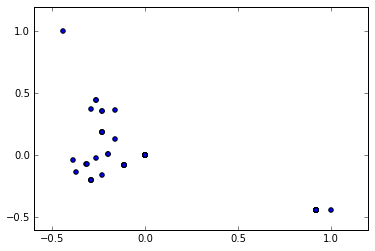

In [14]:
plt.scatter(us_positions, sov_positions)

In [ ]:
import pyobjclipboard
pyobjclipboard.copy_object((us_positions, sov_positions))

In [45]:
np.corrcoef(us_positions, sov_positions)

array([[ 1.        , -0.80674527],
       [-0.80674527,  1.        ]])

In [49]:
from sklearn.decomposition import PCA

In [52]:
X = np.array([us_positions, sov_positions])

In [72]:
pca = PCA(1).fit(X.T)
X_1 = pca.transform(X.T)

In [84]:
pos_max = X_1.max()
pos_min = X_1.min()

In [90]:
pca.transform([-0.44, 0.99]) # US Position

array([[ 1.03453391]])

In [92]:
a[0,0]

1.034533906465271

## Build table

In [83]:
cinc_vals = cinc.set_index("statenme")["cinc"]

In [96]:
data = []
actors = cinc.statenme.unique()
for actor in actors:
    row = {"Country": actor}
    us_pos = get_tau(actor, "United States of America", p_val=False)
    sov_pos = get_tau(actor, "Russia", p_val=False)
    pos = pca.transform([sov_pos, us_pos])[0,0]
    row["Position"] = (pos - pos_min) / (pos_max - pos_min)
    row["Capability"] = cinc_vals[actor]
    data.append(row)

In [97]:
data = pd.DataFrame(data)

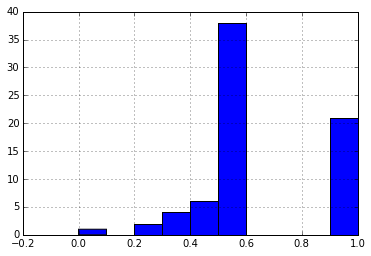

In [99]:
data.Position.hist()

In [100]:
filename = "ColdWarActors_{}.csv".format(start_year)
data.to_csv(filename)